In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


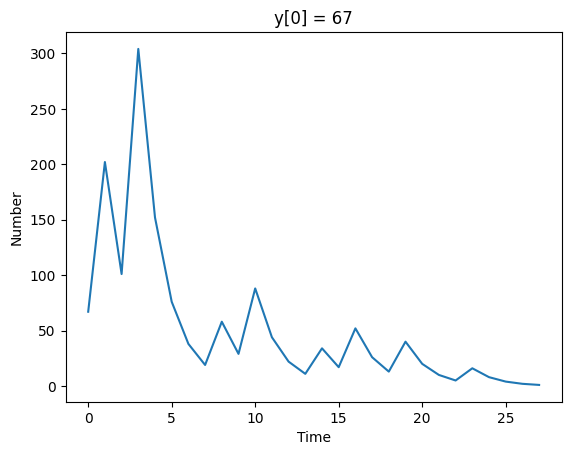

In [2]:
# generate some data
val = 67
nums = [val]
while val != 1:
    if val % 2 == 0:
        val /= 2
    else:
        val = 3 * val + 1
    nums.append(val)

# plot the data
plt.plot(nums)
plt.xlabel('Time')
plt.ylabel('Number')
plt.title('y[0] = 67')
plt.savefig('figs/3xplus1.png')

In [3]:
# Visualization of prediction
N = 1000
series = np.sin(np.linspace(0, 100, N)) + np.random.randn(N) + 0.5 * np.linspace(0, 20, N)

# split into past and future
future_N = 300
past = series[:-future_N]
future = series[-future_N:]

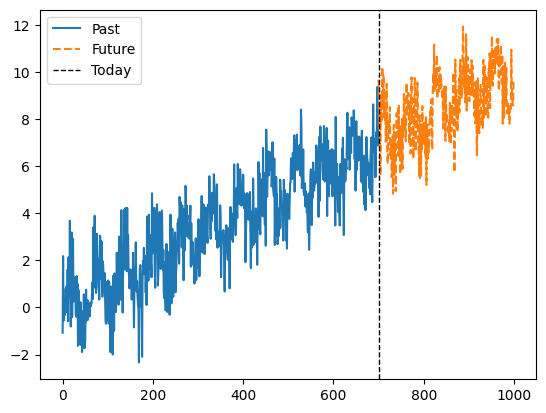

In [4]:
def plot_past_future():     
    plt.plot(np.arange(N - future_N), past, label='Past')
    plt.plot(np.arange(N - future_N, N), future, '--', label='Future')
    plt.axvline(x=N - future_N, color='k', linestyle='--', linewidth=1, label='Today')

plot_past_future()
plt.legend()
plt.savefig("figs/simple_time_series.png")
    

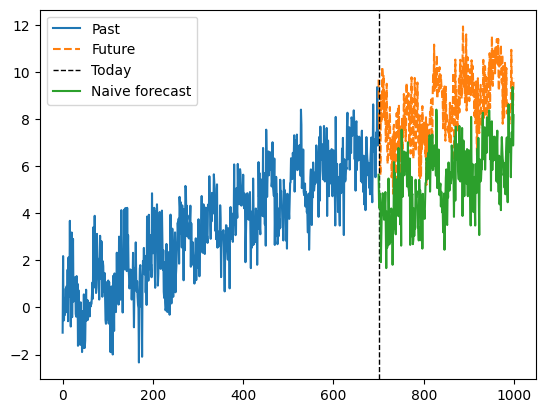

In [5]:
# Naive approach - just shift the series by some amount
naive_forecast = past[-future_N:]

plot_past_future()
plt.plot(np.arange(N - future_N, N), naive_forecast, label='Naive forecast')
plt.legend()

In [21]:
# prepare the data for RNN
def to_ds(data, input_width=10, batch_size=32, next_target=True):
    input_data = data[:-input_width]
    if next_target:
        targets = data[input_width:]
    else:
        targets = None
    return tf.keras.utils.timeseries_dataset_from_array(
        input_data, 
        targets, 
        sequence_length=input_width,
        batch_size=batch_size)
    
train = to_ds(past[:-100])
val = to_ds(past[-100:])
test = to_ds(future)

first_sample = train.take(1).as_numpy_iterator().next()
print(f'Input data shape: {first_sample[0].shape}')
print(f'Output data shape: {first_sample[1].shape}')
print(first_sample[0])

Input data shape: (32, 10)
Output data shape: (32,)
[[-1.06913802  2.1801278  -0.51304318 -0.54804571  0.36252168 -0.31883263
   0.21118651  0.80512077  0.20344927  0.91136813]
 [ 2.1801278  -0.51304318 -0.54804571  0.36252168 -0.31883263  0.21118651
   0.80512077  0.20344927  0.91136813 -0.20659716]
 [-0.51304318 -0.54804571  0.36252168 -0.31883263  0.21118651  0.80512077
   0.20344927  0.91136813 -0.20659716  1.60473355]
 [-0.54804571  0.36252168 -0.31883263  0.21118651  0.80512077  0.20344927
   0.91136813 -0.20659716  1.60473355 -0.58313672]
 [ 0.36252168 -0.31883263  0.21118651  0.80512077  0.20344927  0.91136813
  -0.20659716  1.60473355 -0.58313672  2.1249191 ]
 [-0.31883263  0.21118651  0.80512077  0.20344927  0.91136813 -0.20659716
   1.60473355 -0.58313672  2.1249191   0.4639808 ]
 [ 0.21118651  0.80512077  0.20344927  0.91136813 -0.20659716  1.60473355
  -0.58313672  2.1249191   0.4639808   0.59330643]
 [ 0.80512077  0.20344927  0.91136813 -0.20659716  1.60473355 -0.58313672

In [7]:
# define a simple model
fcn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[None, 10]),
    tf.keras.layers.Dense(1),
])

fcn_model.compile(loss='mse', optimizer='adam')
history = fcn_model.fit(train, epochs=100, validation_data=val)



Epoch 1/100

19/19 [==============================] - 1s 9ms/step - loss: 42.7025 - val_loss: 87.3436
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 14.5004 - val_loss: 24.8990
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 4.5084 - val_loss: 4.9883
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 2.5292 - val_loss: 1.8745
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 2.4172 - val_loss: 1.7267
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 2.4004 - val_loss: 1.7196
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 2.3721 - val_loss: 1.7250
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 2.3438 - val_loss: 1.7141
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 2.3149 - val_loss: 1.6938
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 2.2859 - val_loss: 1.6745
Ep

In [8]:
# Now let's try a simple RNN
simple_rnn = tf.keras.models.Sequential([
    # notice our input shape is now 1 instead of 10! We're only feeding a single time step at a time
    tf.keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_rnn.compile(loss='mse', optimizer='adam')
history = simple_rnn.fit(train, epochs=100, validation_data=val)

Epoch 1/100
19/19 [==============================] - 1s 11ms/step - loss: 2.1925 - val_loss: 2.5234
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2744 - val_loss: 1.1663
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 1.3021 - val_loss: 1.1905
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2730 - val_loss: 1.1588
Epoch 5/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2554 - val_loss: 1.1384
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2443 - val_loss: 1.1317
Epoch 7/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2307 - val_loss: 1.1212
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2230 - val_loss: 1.1157
Epoch 9/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2136 - val_loss: 1.1117
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 1.2077 - val_loss: 1.1082
Epoch 11

In [9]:
# look at each model
print(fcn_model.summary())
print(simple_rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 10)          110       
                                                                 
 dense_1 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                         

9/9 [==============================] - 0s 1ms/step


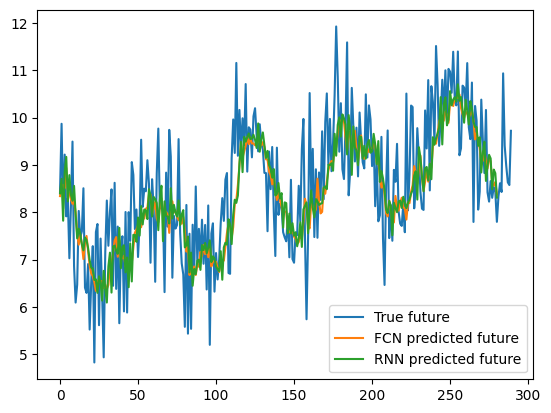

In [10]:
# predict on the test set and compare
fcn_predictions = fcn_model.predict(test)
rnn_predictions = simple_rnn.predict(test)
plt.plot(future[10:], label='True future')
plt.plot(fcn_predictions, label='FCN predicted future')
plt.plot(rnn_predictions, label='RNN predicted future')
plt.legend()

In [11]:
# maybe deeper is better?
deep_rnn = tf.keras.models.Sequential([
    # for each intermediate layer, make sure to set return_sequences=True to feed into the next layer
    tf.keras.layers.SimpleRNN(20, input_shape=[None, 1],  activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(20, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(20, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(20, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(20, activation='relu'),
    tf.keras.layers.Dense(1),
])

deep_rnn.compile(loss='mse', optimizer='adam')

history = deep_rnn.fit(train, epochs=100, validation_data=val)

Epoch 1/100
19/19 [==============================] - 3s 29ms/step - loss: 3.9190 - val_loss: 1.8171
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 1.5596 - val_loss: 1.2881
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 1.3993 - val_loss: 1.2028
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 1.4221 - val_loss: 1.2059
Epoch 5/100
19/19 [==============================] - 0s 8ms/step - loss: 1.4986 - val_loss: 1.2224
Epoch 6/100
19/19 [==============================] - 0s 7ms/step - loss: 1.5137 - val_loss: 1.4332
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 1.3617 - val_loss: 1.3154
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 1.3115 - val_loss: 1.2152
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 1.2951 - val_loss: 1.2536
Epoch 10/100
19/19 [==============================] - 0s 8ms/step - loss: 1.2733 - val_loss: 1.2665
Epoch 11

9/9 [==============================] - 0s 2ms/step


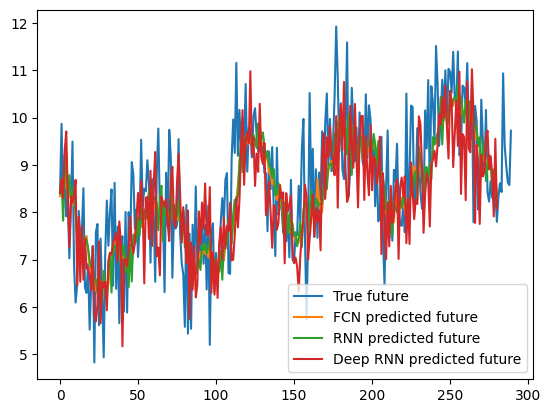

In [12]:
deep_predictions = deep_rnn.predict(test)
plt.plot(future[10:], label='True future')
plt.plot(fcn_predictions, label='FCN predicted future')
plt.plot(rnn_predictions, label='RNN predicted future')
plt.plot(deep_predictions, label='Deep RNN predicted future')
plt.legend()

Text(0, 0.5, 'Maximum Hourly Temperature (C)')

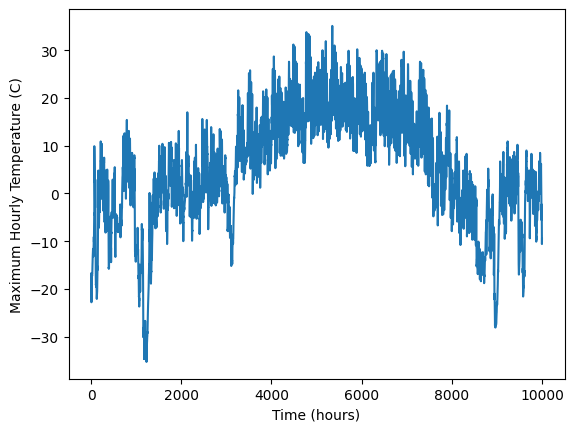

In [13]:
# real dataset
import pandas as pd

weather = pd.read_csv("calgary_weather.csv")
max_temp = weather['max_air_temp_pst1hr'].values

plt.plot(max_temp)
plt.xlabel('Time (hours)')
plt.ylabel('Maximum Hourly Temperature (C)')

In [14]:
# Choose a reasonable time frame to split the data
window = 6

temp_train = to_ds(max_temp[:8000], input_width=window)
temp_val = to_ds(max_temp[8000:9000], input_width=window)
temp_test = to_ds(max_temp[9000:], input_width=window)

# define a simple FCN
temp_fcn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[None, window]),
    tf.keras.layers.Dense(1),
])

temp_fcn_model.compile(loss='mse', optimizer='adam')
history = temp_fcn_model.fit(temp_train, epochs=100, validation_data=temp_val)


Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 37.5011 - val_loss: 4.1529
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 5.4356 - val_loss: 3.8149
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 4.8326 - val_loss: 3.4917
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 4.2464 - val_loss: 3.2009
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 3.7054 - val_loss: 2.9329
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 3.2187 - val_loss: 2.6783
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 2.7938 - val_loss: 2.4388
Epoch 8/100
250/250 [==============================] - 0s 1ms/step - loss: 2.4366 - val_loss: 2.2204
Epoch 9/100
250/250 [==============================] - 0s 1ms/step - loss: 2.1482 - val_loss: 2.0297
Epoch 10/100
250/250 [==============================] - 0s 1ms/step - loss: 1.9253 - val_l

In [15]:
# And now the simple RNN
temp_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(10, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

temp_rnn.compile(loss='mse', optimizer='adam')
history = temp_rnn.fit(temp_train, epochs=100, validation_data=temp_val)

Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 150.2520 - val_loss: 54.8122
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 101.3037 - val_loss: 41.5204
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 78.6383 - val_loss: 31.8400
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 61.8723 - val_loss: 25.0120
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 49.2371 - val_loss: 19.9999
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 39.5870 - val_loss: 16.2721
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 32.1521 - val_loss: 13.4659
Epoch 8/100
250/250 [==============================] - 0s 2ms/step - loss: 26.3816 - val_loss: 11.3311
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 21.8659 - val_loss: 9.6766
Epoch 10/100
250/250 [==============================] - 0s 2ms/step - lo

31/31 [==============================] - 0s 1ms/step


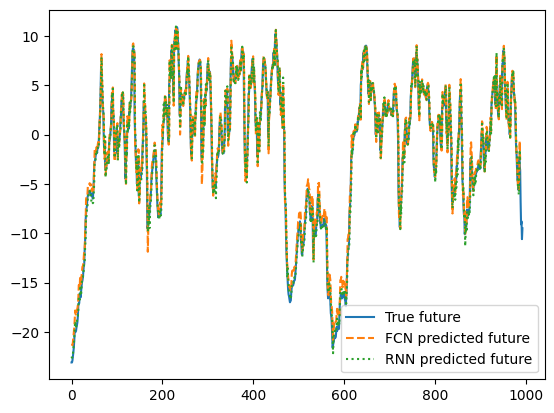

In [16]:
# Plot and compare
fcn_predictions = temp_fcn_model.predict(temp_test)
rnn_predictions = temp_rnn.predict(temp_test)
plt.plot(max_temp[9000 + window:], label='True future')
plt.plot(fcn_predictions, linestyle='--', label='FCN predicted future')
plt.plot(rnn_predictions, linestyle=':', label='RNN predicted future')
plt.legend()

1/1 [==============================] - 0s 104ms/step


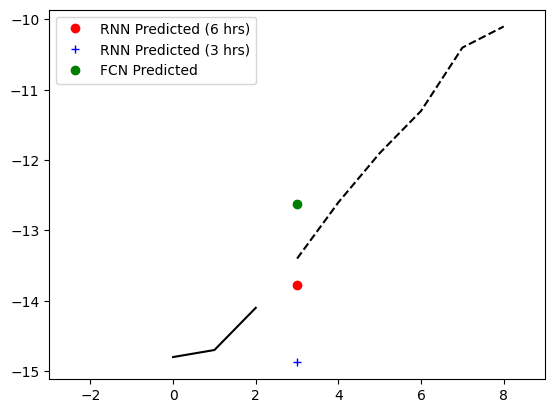

In [17]:
# What's the advantage of RNNs?
# try predicting on some chunk of data
chunk_end = 9500
chunk_length = 6
chunk = max_temp[chunk_end - chunk_length:chunk_end]
truth = max_temp[chunk_end]
r_predicted_6 = temp_rnn.predict(chunk.reshape(1, -1, 1))
f_predicted = temp_fcn_model.predict(chunk.reshape(1, -1))
chunk_length = 3
chunk = max_temp[chunk_end - chunk_length:chunk_end]
r_predicted_var = temp_rnn.predict(chunk.reshape(1, -1, 1))

# what's the error?
plt.plot(chunk, 'k')
plt.plot(np.arange(chunk_length, chunk_length + window), max_temp[chunk_end:chunk_end + window], 'k--')
plt.plot(chunk_length, r_predicted_6, 'ro', label='RNN Predicted (6 hrs)')
plt.plot(chunk_length, r_predicted_var, 'b+', label=f'RNN Predicted ({chunk_length} hrs)')
plt.plot(chunk_length, f_predicted, 'go', label='FCN Predicted')
plt.xlim([chunk_length - window, chunk_length + window])
plt.legend()


In [18]:
# Try a GRU
temp_gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(10, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

temp_gru.compile(loss='mse', optimizer='adam')
history = temp_gru.fit(temp_train, epochs=100, validation_data=temp_val)


Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 133.9022 - val_loss: 65.3382
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 84.4163 - val_loss: 42.0093
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 61.7050 - val_loss: 26.9770
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 46.9468 - val_loss: 20.4644
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 36.9571 - val_loss: 15.6407
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 29.5074 - val_loss: 12.6019
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 23.9212 - val_loss: 10.4956
Epoch 8/100
250/250 [==============================] - 1s 3ms/step - loss: 19.6656 - val_loss: 8.8759
Epoch 9/100
250/250 [==============================] - 1s 3ms/step - loss: 16.3430 - val_loss: 7.6067
Epoch 10/100
250/250 [==============================] - 1s 3ms/step - loss

In [19]:
# Plot and compare
truth = max_temp[9000 + window:-window+1]
gru_predictions = temp_gru.predict(temp_test)
rnn_error = np.abs(rnn_predictions[:,0] - truth)
gru_error = np.abs(gru_predictions[:,0] - truth)

# mean error
print(f'RNN mean absolute error: {np.mean(rnn_error):.2f} C')
print(f'GRU mean absolute error: {np.mean(gru_error):.2f} C')

31/31 [==============================] - 1s 2ms/step
RNN mean absolute error: 0.78 C
GRU mean absolute error: 0.74 C
